In [40]:
image_path = 'dataset/plate/group2-01.czi'
median_filtering = (7,7,7)
second_filtering = (5,5)
nuclei_median_filtering = (3,3,3)
# bead radius:
rad_ = 1.0

In [28]:
# Importing necessary libraries and defining functions for the analysis:
import numpy as np
from czifile import CziFile
from skimage.filters import threshold_li
import scipy
import matplotlib.pyplot as plt
from skimage.measure import label   
from scipy import ndimage
from fil_finder import FilFinder2D
import astropy.units as u
from skimage.morphology import skeletonize as skeletonize_sci

def getLargestCC(segmentation):
    labels = label(segmentation)
    assert(labels.max() != 0)
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    return largestCC

def modified_max_inscribed_circle(bw, f):    
    D = ndimage.distance_transform_edt(bw)
    Rs = -np.sort(-D, axis=None)
    R = Rs[0]
    RInds = np.argsort(-D, axis=None)
    RInds = RInds[Rs >= f*R]
    [cy, cx] = np.unravel_index(RInds, D.shape)
    return R, cx, cy

def create_circular_mask(h, w, center=None, radius=None):
    if center is None: 
        center = (int(w/2), int(h/2))
    if radius is None: 
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

with CziFile(image_path) as im:
    image_array = im.asarray()

# checking the shape of the array
print(image_array.shape)

(1, 1, 1, 2, 41, 1024, 1024, 1)


In [30]:
# defining the correct channels into new arrays based on the above (3) shape
im_sprout = image_array[0,0,0,0,:,:,:,0]
im_nuclei = image_array[0,0,0,1,:,:,:,0]

# Opening napari
import napari
viewer = napari.view_image(im_sprout, name='im_sprout')

Exception in callback BaseAsyncIOLoop._handle_events(7068, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(7068, 1)>
Traceback (most recent call last):
  File "C:\Users\musta\.conda\envs\mb22\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\musta\.conda\envs\mb22\lib\site-packages\tornado\platform\asyncio.py", line 206, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\musta\.conda\envs\mb22\lib\site-packages\zmq\eventloop\zmqstream.py", line 577, in _handle_events
    self._handle_recv()
  File "C:\Users\musta\.conda\envs\mb22\lib\site-packages\zmq\eventloop\zmqstream.py", line 606, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\musta\.conda\envs\mb22\lib\site-packages\zmq\eventloop\zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\musta\.conda\envs\mb22\lib\site-packages\jupyter_client\threaded.py", line 123, in _handle_recv
    msg_list = se

In [31]:
# median filtering the sprout channel
med_sprout = im_sprout
med_sprout = scipy.ndimage.median_filter(med_sprout, size=median_filtering)

viewer.add_image(med_sprout, name="med_sprout")    

# taking the maximum projection of the sprout channel and checking if median filtering size is ok
max_proj_0 = np.max(im_sprout, axis=0)
viewer.add_image(max_proj_0, name="max_projection") 

max_projection = np.max(med_sprout, axis=0)
viewer.add_image(max_projection, name="max_projection")  

# thresholding the max projection and filling the holes
from skimage.filters import threshold_otsu
bw_mproj = max_projection >= threshold_otsu(max_projection)
viewer.add_image(bw_mproj, name="threshold_otsu")  

largest_cc = getLargestCC(bw_mproj)
viewer.add_image(largest_cc, name="largest_cc")  

bw = ndimage.binary_fill_holes(largest_cc) * 1
viewer.add_image(bw, name="fill_holes")  

# median filtering to make the sprouts smoother. 
# If the sprouts are not smooth, the analysis might find the skeleton wrong.
med_bw = scipy.ndimage.median_filter(bw, size=second_filtering)
viewer.add_image(med_bw, name="med_bw")

skeleton_sci = skeletonize_sci(med_bw)
# Check bw, med_bw, skeleton images to see if you need to change the size of median filtering above, before passing this part. 
viewer.add_labels(skeleton_sci, name="skeleton_sci")

C:\Users\musta\.conda\envs\mb22\lib\weakref.py:383: RuntimeWarning: coroutine 'get_msg' was never awaited
  self._iterating = set()


<Labels layer 'skeleton_sci' at 0x1f6a4dfbf40>

C:\Users\musta\.conda\envs\mb22\lib\site-packages\astropy\units\quantity.py:611: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\musta\.conda\envs\mb22\lib\site-packages\astropy\units\quantity.py:611: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


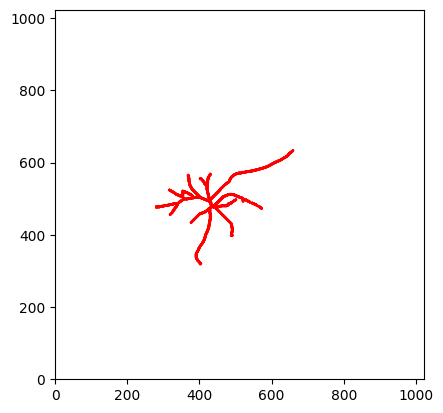

C:\Users\musta\.conda\envs\mb22\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


In [32]:
# Fil-finder analysis of skeletons
# As long as it shows the branches, it is ok to continue with possible errors.
fil = FilFinder2D(med_bw, ang_scale=0.1*u.deg, beamwidth=1*u.arcsec, mask=med_bw)
fil.preprocess_image(flatten_percent=90)
fil.medskel(verbose=True)
fil.analyze_skeletons(skel_thresh=10*u.pix, prune_criteria="length")
branch_tables = fil.branch_tables()

In [33]:
# defining the sprout area, bead and labeling the sprouts
bb = fil.filament_extents
num_skl = fil.branch_properties['number'].squeeze()
pix_skl = fil.branch_properties['pixels'][0]
pix_skl = [x+bb[0][0] for x in pix_skl]

R, cx, cy = modified_max_inscribed_circle(bw, f=0.9)
sz = bw.shape
bead = np.zeros(sz, dtype=bool)
if len(cx) > 200: sp = 10
else: sp = 20 
for i in range(0, len(cx), sp):
    # You can change radius by changing rad_ value in the beginning to get the correct seperation of sprouts
    circ_ = create_circular_mask(sz[0], sz[1], center=(cx[i],cy[i]), radius=R*rad_)
    bead = np.logical_or(bead, circ_)
viewer.add_image(bead, name="bead")

bw_rmv_bead = np.logical_and(med_bw, np.logical_not(bead))
labels = label(bw_rmv_bead)
lbls = np.unique(labels[(fil.skeleton).astype(np.bool_)])
lbls_inx = np.nonzero(lbls)[0]

L = 1
sprouts = np.zeros(sz, dtype=np.uint8)
for i in lbls_inx:
    sprouts[labels==lbls[i]] = L
    L += 1
viewer.add_labels(sprouts, name="sprouts")

<Labels layer 'sprouts' at 0x1f6b1344a90>

In [34]:
# Nuclei segmentation part begins
# importing the necessary libraries, median filtering the nuclei array and creating a maximum projection image
from skimage.transform import resize
from skimage.segmentation import morphological_chan_vese, checkerboard_level_set
from skimage.measure import label, regionprops
from scipy.ndimage import gaussian_filter
from skimage.morphology import local_maxima
import skimage.graph

def shortest_path(bw, st_p, end_p):         
    costs = np.where(bw, 1, 1000)
    path, cost = skimage.graph.route_through_array(
        costs, start=st_p, end=end_p, fully_connected=True)
    return path, cost

viewer.add_image(im_nuclei, name="im_nuclei")
med_nuclei = im_nuclei
for _ in range(2):
    med_nuclei = scipy.ndimage.median_filter(med_nuclei, size=nuclei_median_filtering)
viewer.add_image(med_nuclei, name="med_nuclei")

max_projection_n = np.max(med_nuclei, axis=0)
viewer.add_image(max_projection_n, name="max_projection_n")

<Image layer 'max_projection_n' at 0x1f6ba845c60>

In [ ]:
# Optional: if you want to define an area to get rid of the extra parts at the sides of the image:
# Example:
# med_n_ds[:,:,480:512] = 0
# plt.imshow(med_n_ds[10,:,:])

In [35]:
# Nuclei segmentation continues, omitting bead part (bead2) and other beads/migrated cells (bw_not)
bead2 = np.zeros(sz, dtype=bool)
bw_not = np.logical_not(bw)

if len(cx) > 200: sp = 10
else: sp = 20 
for i in range(0, len(cx), sp):
    # You can change radius to R*n in order to get the correct seperation of sprouts
    circ_2 = create_circular_mask(sz[0], sz[1], center=(cx[i],cy[i]), radius=R*1)
    bead2 = np.logical_or(bead2, circ_2)


med_nuclei2 = med_nuclei.copy()
for i in range(med_nuclei.shape[0]):
    med_nuclei2[i,:,:][np.where(bead2)] = 0
    med_nuclei2[i,:,:][np.where(bw_not)] = 0
    #np.logical_and(med_nuclei2[i,:,:], np.logical_not(bead2))

viewer.add_image(med_nuclei2, name="med_nuclei2")

# Downsize the image if it is large, so that the segmentation will not take so much time depending on the computing power.
if med_nuclei.shape[1] >= 2048:
    md = 4
elif med_nuclei.shape[1] == 1024:
    md = 2
else:
    md = 1
med_n_ds = (med_nuclei2[:, ::md, ::md]).astype(np.float64)
viewer.add_image(med_n_ds, name="med_n_ds")

<Image layer 'med_n_ds' at 0x1f6b13189a0>

In [36]:
# Chan-Vese segmentation:
# increasing/decreasing iterations for more precise detection of nuclei.
# Decrease iterations if not enough nuclei segmented. For details you can check scikit image chan-vese segmentation.
# If checkerboard segmentation does not work, alternatively you can use mask_alternate as the mask instead of checkerboard
max_proj_med_nuclei2 = np.max(med_nuclei2, axis=0)
mask_alternate = np.zeros(med_nuclei2.shape)
for i in range(med_nuclei2.shape[0]):
    mask_alternate[i,:,:] = max_proj_med_nuclei2
mask2 = (mask_alternate[:, ::md, ::md]).astype(np.float64)

bw_n = morphological_chan_vese(image=med_n_ds, num_iter=6, init_level_set=mask2, lambda1=1, lambda2=1) 
viewer.add_labels(bw_n, name="bw_n")

<Labels layer 'bw_n' at 0x1f6b1319540>

In [37]:
# Optional!
# If it is easier to see/check using 2D projections, check the segmentation using this part.
max_proj_bwn = np.max(bw_n, axis=0)
max_proj_med_n_ds = np.max(med_n_ds, axis=0)

viewer.add_image(max_proj_med_n_ds, name="med_n_ds2")
viewer.add_labels(max_proj_bwn, name="bw_n2")
# if satisfied continue.

<Labels layer 'bw_n2' at 0x1f6bfc97cd0>

(<Figure size 640x480 with 1 Axes>,
 (array([0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 3., 0., 0., 0., 0., 2.,
         2., 3., 1., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([   0.,   10.,   20.,   30.,   40.,   50.,   6

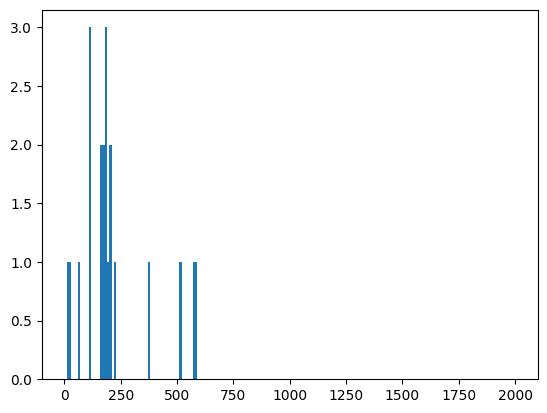

In [38]:
# Histogram of objects. To select the area threshold and correct object afterwards.
bw_nn = bw_n.astype(np.bool_)
bw_nn = (resize(bw_nn, output_shape=(med_nuclei.shape), order=0)).astype(np.bool_)
lbl_n = label(bw_nn, connectivity=1)
stats = regionprops(lbl_n)
label_n, area_n, eqds_n, maj_axis_n, box_n, centroid_n, image_n = [], [], [], [], [], [], []
for p in stats:
    label_n.append(p.label)
    area_n.append(p.area)
    eqds_n.append(p.equivalent_diameter)
    maj_axis_n.append(p.major_axis_length)
    box_n.append(p.bbox)
    centroid_n.append(p.centroid)
    image_n.append(p.image)

objects_library = {"label_n":label_n, "image_n":image_n, "area_n":area_n,
                   "eqds_n":eqds_n, "maj_Axis_n":maj_axis_n, "box_n":box_n, "centroid_n":centroid_n}

# You can change the range of the histogram to see the details
plt.figure(), plt.hist(area_n, bins=200, range=(0,2000))

<Points layer 'rep' at 0x1f6b1580d60>

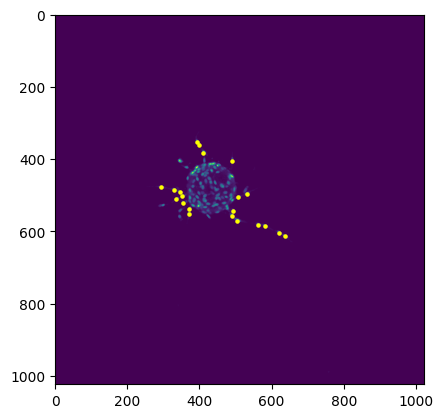

In [39]:
# Nuclei location detection:
# Based on histogram, you can change area_threshold:
area_threshold = [30, 400]
correct_obj = (np.array(objects_library["area_n"])>area_threshold[0]) & (np.array(objects_library["area_n"])<area_threshold[1])
in_range_eqds = np.array(objects_library["eqds_n"])[correct_obj]
cents = np.array(objects_library["centroid_n"])[correct_obj]
cents_f = cents.astype(int)
rep = np.zeros(med_nuclei.shape, dtype=np.bool_)
for i in cents_f:    
    rep[tuple(i)]=True
large_obj = np.array(objects_library["area_n"])>=area_threshold[1]
intensity_thr = 0.1
theta_gd = np.mean(in_range_eqds)
himg = med_nuclei / np.max(med_nuclei)

for i in range(len(large_obj)):
    if large_obj[i]: 
        #print(i)           
        bb = objects_library["box_n"][i]
        D = himg[bb[0]:bb[3], bb[1]:bb[4], bb[2]:bb[5]]        
        B = bw_nn[bb[0]:bb[3], bb[1]:bb[4], bb[2]:bb[5]]
        Dfil = gaussian_filter(np.pad(D, [5]), sigma=0)
        Dfil = Dfil[5:-5, 5:-5, 5:-5]               
        reg_max = local_maxima(Dfil, connectivity=3, indices=False, allow_borders=False)
        reg_max = np.logical_and(reg_max, B)        
        reg_max_idx = np.argwhere(reg_max) 
        if len(reg_max_idx):      
            reg_max_idx = [x for x in reg_max_idx if Dfil[tuple(x)]>=intensity_thr]
            reg_max_value = [Dfil[tuple(x)] for x in reg_max_idx] 
            ranked = np.argsort(reg_max_value)[::-1]            
            reg_max_idx = [reg_max_idx[x] for x in ranked]
            flags = np.ones(len(reg_max_idx), dtype=bool)
            for j in range(len(reg_max_idx)):
                if flags[j]:
                    for k in range(j+1, len(reg_max_idx)):                                                                                         
                        path_seq, cost = shortest_path(B, reg_max_idx[j], reg_max_idx[k])
                        if cost<theta_gd:
                            flags[k] = False    
            reg_max_idx = np.array(reg_max_idx)[flags]
        for x in reg_max_idx:
            x = tuple((x[0]+bb[0], x[1]+bb[1], x[2]+bb[2]))
            rep[tuple(x)]=True
vis_rep = np.max(rep, axis=0)

#print(rep)

[rr, cc] = np.where(vis_rep)
plt.figure(), plt.imshow(max_projection_n)
plt.scatter(cc, rr, s=5, c='yellow')

dots = []
for i in range(len(rr)):
    dots.append((rr[i],cc[i]))

max_proj_nuclei = np.max(med_nuclei2, axis=0)
viewer.add_image(max_proj_nuclei, name="max_proj_nuclei")
viewer.add_points(dots, name="rep", size=5, face_color='yellow')

1 skeleton length is: 71
2 skeleton length is: 20
3 skeleton length is: 58
3 paired_dist_in_this_sprout: []
4 skeleton length is: 71
5 skeleton length is: 16
6 skeleton length is: 1
7 skeleton length is: 20
8 skeleton length is: 182


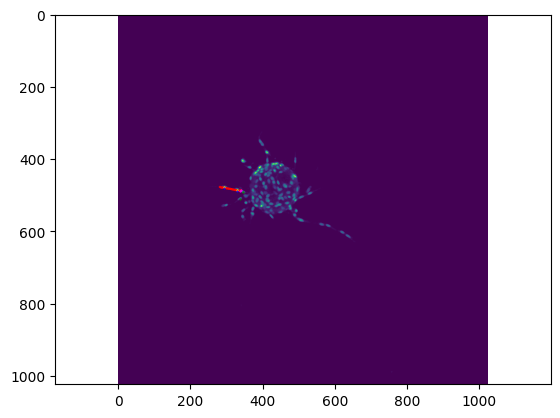

In [24]:
# Lumen space analysis: Regional width and paired nuclei distance analysis
from scipy.ndimage import distance_transform_edt as distance
from scipy.spatial.distance import cdist
def curve_parametrization(L):
    # not entirely correct
    s = L[0]
    dist = np.sum((L-s)**2, axis=1)
    max_inx = np.argmax(dist)
    s = L[max_inx]
    dist = np.sum((L-s)**2, axis=1)
    ranked = np.argsort(dist)[::-1]
    return L[ranked]
def point_in_lineside (points, curve):
    """d=(x−x1)(y2−y1)−(y−y1)(x2−x1), where [x,y] are points to assess,
    and [x1 y1], [x2 y2] form the line segment
    if d>0 or d<0 the point is in either side of the line"""
    dist_to_curve = cdist(points, curve, 'euclidean')
    proj = np.argmin(dist_to_curve, axis=1)
    ll = len(L)-1
    if ll in proj: proj[proj==ll] = ll-1
    proj_ep = proj+1
    d1 = L[proj_ep] - L[proj]
    d2 = rep_coord - L[proj]
    d = (d2[:,1] * d1[:,0]) - (d2[:,0] *  d1[:,1])
    return d

skeleton = pix_skl
skeleton = [curve_parametrization(L) for L in skeleton]
num_sp = sprouts.max()
num_skl = len(skeleton)
mproj = np.logical_or(bead, sprouts)
D = distance(mproj)
rep_2d = np.max(rep, axis=0)
mproj_n = np.max(med_nuclei, axis=0)
plt.imshow(np.max(med_nuclei, axis=0))
i_list = []
skel_len_list = []
tip_width_list = []
stalk_width_list = []
root_width_list = []
paired_dist_list = []

for i in range(1, num_sp+1):
    sprout_name = str(i)
    prop = {"sp_skeleton":[]}
    sp = sprouts==i    
    skl_intsc = np.zeros(num_skl)
    for j in range(len(skeleton)):
        L = skeleton[j]
        intsc = np.array([sp[tuple(x)] for x in L])
        skl_intsc[j] = intsc.sum()
    max_inx = np.argmax(skl_intsc)
    L = skeleton[max_inx]
    intsc = np.array([sprouts[tuple(x)] for x in L])
    non_z = intsc!=0
    L = L[non_z,:]
    if non_z[0]==False:
        L = np.flipud(L)
    prop = {"sp_skeleton": L}
    prop["sp_skel_len"] = len(L) #>>chnge
    thick = np.array([D[tuple(x)] for x in L])
    prop["thick"] = thick
    print(sprout_name,"skeleton length is:",len(L))
    skel_len_list.append(len(L))
    
    if len(L)>30:
        tip_sp = int(0.25*len(L)); tip_sp = range(tip_sp-2,tip_sp+2)
        mid_sp = int(0.50*len(L)); mid_sp = range(mid_sp-2,mid_sp+2)
        end_sp = int(0.75*len(L)); end_sp = range(end_sp-2,end_sp+2)
        prop["tip_width"] = np.mean(thick[tip_sp])*2
        prop["stalk_width"] = np.mean(thick[mid_sp])*2
        prop["root_width"] = np.mean(thick[end_sp])*2
        
        tip_width_list.append(prop["tip_width"])
        stalk_width_list.append(prop["stalk_width"])
        root_width_list.append(prop["root_width"])
        
    else:
        mid_sp = int(0.50*len(L)); mid_sp = range(mid_sp-1,mid_sp+1)
        prop["stalk_width"] = np.mean(thick[mid_sp])*2
        stalk_width_list.append(prop["stalk_width"])

    rep_sp = np.logical_and(sp, rep_2d)
    rep_coord = np.array(np.where(rep_sp)).T
    if len(rep_coord)==0:
        prop["paired_n"] = []
        prop["paired_dist"] = []
        continue
    d = point_in_lineside (rep_coord, L)
    rep1 = rep_coord[d>0]
    rep2 = rep_coord[d<0]
    if len(rep1)>len(rep2):
        rep1 = rep_coord[d<0]
        rep2 = rep_coord[d>0]
    dist_to_curve = cdist(rep1, L, 'euclidean')
    proj1 = L[np.argmin(dist_to_curve, axis=1)]
    dist_to_curve = cdist(rep2, L, 'euclidean')
    proj2 = L[np.argmin(dist_to_curve, axis=1)]
    pair_dist = cdist(proj1, proj2, 'euclidean') 

    if len(pair_dist) > 0:
        mv = np.min(pair_dist, axis=1)
        mi = np.argmin(pair_dist, axis=1)
        p = np.vstack((range(len(mi)), mi)).T
        a = np.unique(mi)
        paired_n = np.zeros((len(a), 2), dtype=int)
        paired_dist = np.zeros(len(a))
        plt.plot(L[:,1], L[:,0], "r")
        plt.plot(rep1[:,1], rep1[:,0], '.', markersize=1, color="yellow")
        plt.plot(rep2[:,1], rep2[:,0], '.', markersize=1, color="green")
        plt.plot(proj1[:,1], proj1[:,0], '.', markersize=1, color="blue")
        plt.plot(proj2[:,1], proj2[:,0], '.', markersize=1, color="magenta")
        plt.axis('equal')
    
        for ii in range(len(a)):
            bb = np.where(mi==a[ii])[0]
            if len(bb)==1:
                paired_n[ii,:] = p[bb, :]
            else:
                cc = np.argmin(mv[bb])
                paired_n[ii,:] = p[bb[cc], :]
            pp = paired_n[ii, :]
            x1 = np.expand_dims((rep1[pp[0]]), axis=1).T
            x2 = np.expand_dims((rep2[pp[1]]), axis=1).T
        
        # Putting a threshold value for paired distance according to width results:
            if cdist(x1, x2, 'euclidean') < np.max(thick):
                paired_dist[ii] = cdist(x1, x2, 'euclidean')
            else:
                continue
        
            # Putting a threshold value for paired distance according to width results:
            if paired_dist[ii] < np.max(thick):
                x = np.append(x1,x2, axis=0)
                plt.plot(x[:,1], x[:,0])
            else:
                continue
        prop["paired_n"] = paired_n
        prop["paired_dist"] = paired_dist
    
        paired_dist_in_a_sprout=[]
        for i in paired_dist:
            if i > 0:
                paired_dist_in_a_sprout.append(i)
        print(sprout_name,"paired_dist_in_this_sprout:",paired_dist_in_a_sprout)

        if len(paired_dist_in_a_sprout)>0:
            paired_dist_average = sum(paired_dist_in_a_sprout)/len(paired_dist_in_a_sprout)
            print(sprout_name,"paired_dist_average:",paired_dist_average)
            paired_dist_list.append(paired_dist_average)
        else:
            continue
    else:
        continue
    
    fig_xyz = plt.savefig('analyzed_image', dpi = 300)  
    i_list.append(str(i))

nuclei_count = np.count_nonzero(rep)

In [25]:
# Printing the measured results
print("skeleton_length_measurements:",skel_len_list)
print()
print("tip_width_measurements:", tip_width_list)
print("stalk_width_measurements:", stalk_width_list)
print("root_width_measurements:", root_width_list)
print()
print("paired_dist_measurements per sprout:", paired_dist_list)
print()
print("sprout_number:", len(skel_len_list))
print("skeleton_length_avg:",sum(skel_len_list)/len(skel_len_list))
print("nuclei number:",nuclei_count)
print()
print("tip_width_avg",sum(tip_width_list)/len(tip_width_list))
print("stalk_width_avg",sum(stalk_width_list)/len(stalk_width_list))
print("root_width_avg",sum(root_width_list)/len(root_width_list))
print()
if len(paired_dist_list)>0:
    print("paired_dist average per bead:",sum(paired_dist_list)/len(paired_dist_list))

skeleton_length_measurements: [71, 20, 58, 71, 16, 1, 20, 182]

tip_width_measurements: [3.7071067811865475, 6.802775637731995, 3.7071067811865475, 6.767828935632369]
stalk_width_measurements: [8.918941133868262, 5.06449510224598, 4.118033988749895, 8.918941133868262, 3.414213562373095, 8.246211251235321, 6.767828935632369, 6.883914467816185]
root_width_measurements: [7.72865690108165, 5.53224755112299, 7.72865690108165, 5.61338638120718]

paired_dist_measurements per sprout: []

sprout_number: 8
skeleton_length_avg: 54.875
nuclei number: 21

tip_width_avg 5.246204533934365
stalk_width_avg 6.541572446973671
root_width_avg 6.650736933623367

